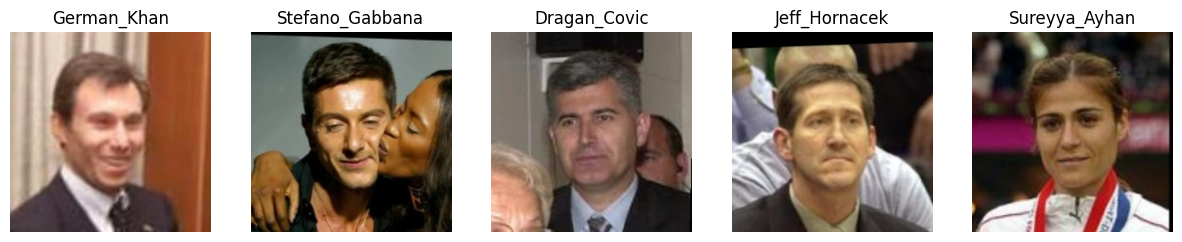

In [1]:

import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from src.utils.utils import load_and_show_images, load_dataset

data_dir = '../data/processed'

load_and_show_images('../data/raw/lfw_funneled')


In [2]:
def analyze_pairs_file(pairs_file):
    with open(pairs_file, 'r') as file:
        lines = file.readlines()
        print(f"Number of pairs in {pairs_file}: {len(lines) - 1}")


analyze_pairs_file('../data/raw/pairs.txt')
analyze_pairs_file('../data/raw/pairsDevTest.txt')
analyze_pairs_file('../data/raw/pairsDevTrain.txt')

Number of pairs in ../data/raw/pairs.txt: 6000
Number of pairs in ../data/raw/pairsDevTest.txt: 1000
Number of pairs in ../data/raw/pairsDevTrain.txt: 2200


In [3]:
from src.models.model import build_srcnn_model
# Build the model

model = build_srcnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 64)    15616     
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    51232     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 3)     2403      
                                                                 
Total params: 69251 (270.51 KB)
Trainable params: 69251 (270.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, None, None, 64)    15616     
                                                              

In [4]:
# Define a custom PSNR metric with max_val specified
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Compile the model with the PSNR metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[psnr_metric])

In [11]:
from src.utils.utils import plot_training_history

low_res_size = (24, 32)
high_res_size = (96, 128)
dataset = load_dataset('../data/raw/lfw_funneled', low_res_size, high_res_size)
dataset = dataset.batch(16).shuffle(buffer_size=100).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


for low_res_img, high_res_img in dataset.take(1):
    print(f"Low resolution image batch shape: {low_res_img.shape}")
    print(f"High resolution image batch shape: {high_res_img.shape}")

Low resolution image batch shape: (16, 96, 128, 3)
High resolution image batch shape: (16, 96, 128, 3)


In [6]:
# Define the split ratios
train_split = 0.7
val_split = 0.15
test_split = 0.15

dataset_size = len(list(dataset))

train_size = int(train_split * dataset_size)
val_size = int(val_split * dataset_size)
test_size = int(test_split * dataset_size)

# Split the dataset
train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

# Train the model with validation
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10)

Epoch 1/10
579/579 [==============================] - 254s 437ms/step - loss: 0.0083 - psnr_metric: 21.7757 - val_loss: 0.0061 - val_psnr_metric: 22.6177
Epoch 2/10
579/579 [==============================] - 265s 457ms/step - loss: 0.0060 - psnr_metric: 22.7176 - val_loss: 0.0060 - val_psnr_metric: 22.7261
Epoch 3/10
579/579 [==============================] - 258s 445ms/step - loss: 0.0058 - psnr_metric: 22.8160 - val_loss: 0.0058 - val_psnr_metric: 22.8297
Epoch 4/10
579/579 [==============================] - 257s 444ms/step - loss: 0.0057 - psnr_metric: 22.9254 - val_loss: 0.0057 - val_psnr_metric: 23.0006
Epoch 5/10
579/579 [==============================] - 256s 442ms/step - loss: 0.0056 - psnr_metric: 22.9733 - val_loss: 0.0055 - val_psnr_metric: 23.0398
Epoch 6/10
579/579 [==============================] - 254s 438ms/step - loss: 0.0056 - psnr_metric: 23.0033 - val_loss: 0.0056 - val_psnr_metric: 23.0244
Epoch 7/10
579/579 [==============================] - 247s 426ms/step - loss

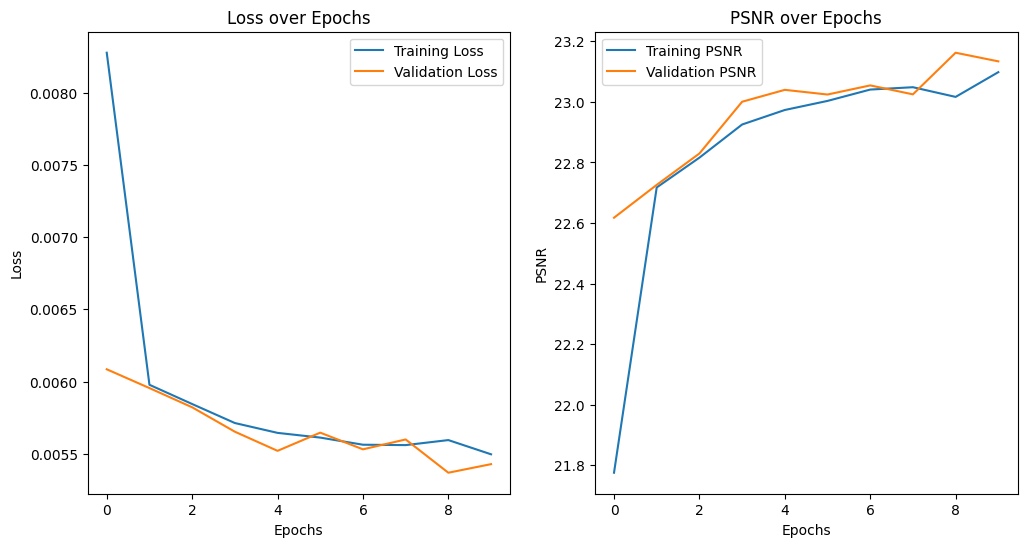

In [13]:
def plot_training_history(history):
    """
    Plots the training and validation loss and metrics over the epochs.

    Args:
    history (History): History object returned by the fit method of a Keras model.
    """

    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot PSNR
    plt.subplot(1, 2, 2)
    plt.plot(history.history['psnr_metric'], label='Training PSNR')
    if 'val_psnr_metric' in history.history:
        plt.plot(history.history['val_psnr_metric'], label='Validation PSNR')
    plt.title('PSNR over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR')
    plt.legend()

    plt.show()

plot_training_history(history)

In [8]:
# Evaluate the model on the test dataset
test_loss, test_psnr = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test PSNR: {test_psnr}")

125/125 [==============================] - 19s 106ms/step - loss: 0.0055 - psnr_metric: 23.0886
Test Loss: 0.005510678049176931, Test PSNR: 23.08860206604004
